In [1]:
import numpy as np
import sys
sys.path.append('..')

import os
import re
import json
import numpy as np
from utils.utils import *
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import trange
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import dill
import matplotlib.pyplot as plt
from tqdm import tqdm
# print(torch.__version__)
# print(torch.version.cuda)
# use_gpu = torch.cuda.is_available()
# use_gpu
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

保存当前变量

In [2]:
# # 保存当前变量
# dill.dump_session('notebook_env_matrix0221.db')
# dill.load_session('notebook_env_matrix0206.db')
# dill.dump_session('load_dataset.db')
# dill.load_session('load_dataset.db')
# dill.dump_session('train_complete.db')

定时关机

In [3]:
# !sleep 30; sh /mistgpu/shutdown.sh

数据初始化

In [4]:
# 设置基础参数和文件路径
l = 10000 # 边的数量
m = 30000 # p空间的数量
n = 300 # 轨迹数据集的大小
# 超参数
mu=10
la=10.0/n
# raw_tras = load_tras("generated_trajectory_dataset_highspeedway20220830.npy")
# raw_tras_sz = load_tras("/home/mist/pathlet/tra_dataset_nanshan19004.npy")
raw_tras_name = "tra_dataset_haidiian21_16_10562"
raw_tras_name = "tra_dataset_haidiian22_16_3132"
raw_tras_name = "tra_dataset_futian4_5_9456"
raw_tras_name = "tra_dataset_futian5_4_56958"
raw_tras_name = "tra_dataset_futian5_5_17530"
raw_tras_name = "tra_dataset_futian5_6_1475"
raw_tras_name = "tra_dataset_futian_p2_31402"
# raw_tras_name ="tra_dataset_nanshan3_6_3038"
raw_tras_sz = load_tras("/root/"+raw_tras_name+".npy")
print("len of raw tras when loading:",len(raw_tras_sz))
tras_,tra_index_list = filter_raw_num_of_edge_6(raw_tras_sz)#由于算力有限，我们只能使用数据集的一部分进行计算 全集为tras_ 子集为tras



# np.save('tra_index_list.npy',np.array(tra_index_list,dtype=object))

len of raw tras when loading: 31402
len of raw tras after filter edges more than 6: 31402
the first trajectory:
[(7973259347, 7973259337, 7973259335, 7973259332, 7973259330, 1491785794, 1491785824), (7973259347, 7973259337, 7973259335, 7973259332, 7973259330, 1491785794, 1491785824, 1491785846, 498882128, 498883178, 7973114657), (7973259337, 7973259335, 7973259332, 7973259330, 1491785794, 1491785824, 1491785846), (7973259350, 7973259347, 7973259337, 7973259335, 7973259332, 7973259330, 1491785794), (7973259330, 1491785794, 1491785824, 1491785846, 498882128, 498883178, 8076307493, 8076307486, 9906792548, 498882100, 7986471687), (1491785824, 1491785846, 498882128, 498883178, 8076307493, 8076307486, 9906792548, 498882100, 7986471687), (498883178, 7973114657, 8869146993, 5187499081, 5187499081, 5187499094, 8792350045, 7973099572, 7973114535, 7973099510, 7973099511, 5274731030, 7975273880, 7975273879, 7973099523, 7973099522, 7973099524, 7973099525, 2530284924, 7973114733, 8076307493, 8076307

In [5]:
# -------------------
filter_num=2
shortest_edge_num = 5
tras = tras_[:15000] 

# 我们需要获得所有的edge并且编号；并且获得所有的t与e的对应关系 这样方便下一步计算矩阵，也就是得到edge_list and path_list
# 先计算一下e和p的大小
edge_list = []
path_list = []
path_list_cnt_ = []
tra_index = 0

# path_list_dict={}#记录不同的pathlet
path_list_dict_cnt={}#记录不同的pathlet对应的被经过的次数
for i in trange(len(tras)):
    tra = tras[i]
    for edge in tra:
        edge_list.append(str(edge).replace(" ",""))  
    for path in generate_all_p(tra,shortest_edge_num,1000):
        path_len = len(path)
        path_str = str(path).replace(" ","")
        path_list.append(path_str)
        if path_str not in path_list_dict_cnt.keys():
            path_list_dict_cnt[path_str]=[1,0]
        else:
            path_list_dict_cnt[path_str][0]+=1
l,m,n = len(edge_list)+10,len(path_list)+10,len(tras)
print("len(edge_list):",l,"len(path_list):",m,"len(tras):",n)
edge_list = list(set(edge_list))           
path_list = list(path_list_dict_cnt.keys())
l,m,n = len(edge_list)+10,len(path_list)+10,len(tras)
print("len(edge_list):",l,"len(path_list):",m,"len(tras):",n)
# 这一次是根据pathlet的frequency来过滤一部分不太常用的path

old_path_list = path_list
path_list = []
path_index=0
for i in range(len(old_path_list)):
    if path_list_dict_cnt[old_path_list[i]][0]>filter_num:
        path_list.append(old_path_list[i])
        path_list_dict_cnt[old_path_list[i]][1]=path_index
        path_index+=1
for i in trange(len(tras)):
    tra = tras[i]
    path_list.append(str(tra).replace(" ",""))
l,m,n = len(edge_list)+10,len(path_list)+10,len(tras)
print("len(edge_list):",l,"len(path_list):",m,"len(tras):",n)

# # 存储pathlet_list
np.save('path_list'+raw_tras_name+'.npy',np.array(path_list,dtype=object))   # 保存为.npy格式
# np.save('edge_list.npy',np.array(edge_list,dtype=object))   # 保存为.npy格式

100%|██████████| 15000/15000 [00:08<00:00, 1723.06it/s]


len(edge_list): 107293 len(path_list): 284188 len(tras): 15000
len(edge_list): 22348 len(path_list): 283850 len(tras): 15000


100%|██████████| 15000/15000 [00:00<00:00, 50988.13it/s]


len(edge_list): 22348 len(path_list): 15071 len(tras): 15000


In [6]:
# 计算三个矩阵
D = np.zeros((l, m)) #记录e与p之间关系
R = np.zeros(( m,n)) #记录p与t之间关系
T = np.zeros((l, n)) #记录e和t之间关系
D_tensor=torch.zeros(len(edge_list)+10,len(path_list)+10)#.cuda()
computed_path = []

tra_index = 0
for i in trange(len(tras)):
    tra = tras[i]
    for edge in tra:
        T[edge_list.index(str(edge).replace(" ",""))][i] = 1
    path_index = path_list.index(str(tra).replace(" ",""))
    R[path_index][i]=1
from tqdm import tqdm
for path in tqdm(path_list):
    path_index = path_list.index(path)
    edge_list_of_temp_pathlet= path_str2list(path)
    for edge in edge_list_of_temp_pathlet:
        if edge in edge_list:
            D_tensor[edge_list.index(edge)][path_index] = 1

D_tensor=D_tensor#.cuda()
T_tensor=torch.from_numpy(T[:len(edge_list)+10])#.cuda()
print('x.dtype: ',D_tensor.dtype)  # x的具体类型
R_tensor_tejie=torch.from_numpy(R[:len(path_list)+10])
# R_tensor=torch.rand(len(path_list)+10,n).double()
# D=np.load("./D.npy",allow_pickle=True)
# T=np.load("./T.npy",allow_pickle=True)
# R=np.load("./R.npy",allow_pickle=True)
# # 保存数据为csv，供matlab使用
# numpy.savetxt("D_tensor_148.csv", D_tensor.cpu().detach().numpy(), delimiter=',')
# numpy.savetxt("T_tensor_148.csv", T_tensor[:,0:30].cpu().detach().numpy(), delimiter=',')

100%|██████████| 15061/15061 [01:06<00:00, 227.04it/s]

x.dtype:  torch.float32


In [7]:
# 可视化pathlet的频次分布
# df_path_list_cnt=pd.DataFrame(path_list_cnt_,columns=["cnt"])

# df_path_list_cnt = df_path_list_cnt.reset_index()
# df_path_list_cnt = df_path_list_cnt.sort_values(by=['cnt'],ascending = False)
# # df_path_list_cnt=df_path_list_cnt[df_path_list_cnt["cnt"]<=100]
# df_path_list_cnt=df_path_list_cnt[df_path_list_cnt["cnt"]>2]

# df_path_list_cnt.hist("cnt",bins=100)
# print(len(df_path_list_cnt))

In [8]:
# 回头看，求得最后字典后，看字典中的pathlet有多少是之前的高频pathlet
# cnt=0
# df_path_list_cnt=df_path_list_cnt[df_path_list_cnt["cnt"]>1]
# rounded_list = list(pathlet_dictionary[pathlet_dictionary["cnt"]>0]["index"])
# from tqdm import tqdm
# for p_id in tqdm(rounded_list):
#     if p_id in list(df_path_list_cnt["index"]):
#         cnt+=1
# print(cnt/len(rounded_list))
    

0空间 与 QD规划

In [9]:
# import torch
# import numpy as np
# # demo
# A = D_tensor.double().cpu()
# # A = torch.tensor([[1, 2, 3],[1, 2, 3]], dtype=torch.float64)
# U, S, V  =torch.linalg.svd(A,full_matrices=True) 
# print(U.shape)
# print(S.shape)
# print(V.shape)

# def get_full_diag_S(S,size):
#     full_diag_S = torch.empty(size[0],size[1], dtype=S.dtype, device=S.device)
#     S_full_list = S.cpu().numpy().tolist()
#     for i in range(size[1]-len(S)):
#         S_full_list.append(0)
#     for i in range(len(S)):
#         full_diag_S[i][i]=S[i]
#     return full_diag_S,S_full_list


# def get_null_space(A,U, S, V):
#     tol = 1e-5
#     zero_eigenvals = (S < tol).nonzero()[:, 0]
#     print(zero_eigenvals)
#     # zero_eigenvals = torch.tensor(list(range(3879,49097)))
#     null_space = torch.empty(A.shape[1], len(zero_eigenvals), dtype=U.dtype, device=U.device)
#     for i, idx in enumerate(zero_eigenvals):
#         null_space[:, i] = (V.T)[:, idx]
#     return null_space

# full_diag_S,S_full_list = get_full_diag_S(S,A.shape)
# # print(full_diag_S)
# # print(S_full_list)

# null_space  = get_null_space(A,U, torch.tensor(S_full_list), V)
# # print("close enough between reconstruction result and raw matrix?")
# # close_res = np.isclose((U@ full_diag_S)@V.T, A,atol=0.1)
# # close_res_cnt =0 
# # for i in trange(close_res.shape[0]):
# #     for j in range(close_res.shape[1]):
# #         if close_res[i][j]==False:
#             # close_res_cnt+=1
# # print(close_res_cnt)
# print("null space compute correct?")
# # print(A@null_space)
# # A_mul_null_space = (A.cuda()@null_space.cuda()).cpu()
# A_mul_null_space = (A@null_space).cpu()
# print("---所有误差绝对值累计---")
# print(torch.norm(A_mul_null_space,1))
# # close_res = np.isclose(A_mul_null_space, torch.zeros(A_mul_null_space.shape),atol=0.01)
# # close_res_cnt =0 
# # for i in trange(close_res.shape[0]):
# #     for j in range(close_res.shape[1]):
# #         if close_res[i][j]==False:
# #             close_res_cnt+=1
# # print(close_res_cnt)


# 训练开始

In [10]:
# # print('x.dtype: ',D_tensor.dtype)  # x的具体类型
# # print('x.dtype: ',torch.zeros( m,n).dtype)  # x的具体类型
# null_space=null_space.cuda()

# R_tensor = torch.tensor(R).double().cuda()

# R_tensor.requires_grad=True
# if_subset=0
# a = torch.sum(torch.max(R_tensor,1).values*(1-if_subset)).cuda()
# b = 1*torch.norm(R_tensor,1).cuda()
# res = (a+b)
# print(res)

# res.backward()
# print(R_tensor.grad)

# R_tensor.data = R_tensor.data- 0.001*null_space@null_space.T@R_tensor.grad

In [11]:
# from tensorboardX import SummaryWriter
# def R_train2(null_space,initial_R,D_tensor,T_tensor,if_subset,num_of_subset,lambda_value,mu_value1,mu_value2,mu_value3,mu_value4,epoch_num,LR,gamma_value):
#     # print("-------------------------------------------------lambda_value=",lambda_value)
#     writer = SummaryWriter('/root/tf-logs')
#     R_tensor = initial_R.double().cuda()
#     R_tensor.requires_grad=True
    
#     # scheduler_1 = StepLR(opt, step_size=100, gamma=gamma_value)
#     diff_norm_num=1
#     start_opt_rounding_ratio = 0.3
#     # relu = torch.nn.ReLU()
#     # loss_his = [[],[],[],[],[],[],[]]
#     # real_mu_value1 = torch.ones(T_tensor.size()).cuda()
#     # real_mu_value3 = torch.ones(1).cuda()
    

#     # real_mu_value1.requires_grad=True
#     # real_mu_value3.requires_grad=True
#     # opt  = torch.optim.Adam([R_tensor,real_mu_value1,real_mu_value3], lr=LR)
#     # -------------------------start iteration------------------------------------- #
#     null_space=null_space.cuda()

#     R_tensor = torch.tensor(R).double().cuda()

#     R_tensor.requires_grad=True
#     if_subset=0
#     a = torch.sum(torch.max(R_tensor,1).values*(1-if_subset)).cuda()
#     b = 1*torch.norm(R_tensor,1).cuda()
#     res = (a+b)
#     print(res)

#     res.backward()
#     print(R_tensor.grad)

#     R_tensor.data = R_tensor.data- 0.001*null_space@null_space.T@R_tensor.grad
#     a = torch.sum(torch.max(R_tensor,1).values*(1-if_subset)).cuda()
#     b = 1*torch.norm(R_tensor,1).cuda()
#     res = (a+b)
#     print(res)

#     res.backward()
#     print(R_tensor.grad)

#     R_tensor.data = R_tensor.data- 0.001*null_space@null_space.T@R_tensor.grad
#     print("0000")
#     for i in trange(epoch_num):
#         # temp_tensor = (D_tensor@R_tensor - T_tensor).cuda()
         
#         a = torch.sum(torch.max(R_tensor,1).values*(1-if_subset)).cuda()
#         b = lambda_value*torch.norm(R_tensor,1).cuda()
        
#         # mu = 0 invalidate these two terms
#         # if mu_value1!=0:
#         #     c =  mu_value1*(torch.norm((temp_tensor)*(temp_tensor),diff_norm_num)) 
#         #     # c = (real_mu_value1.mul(temp_tensor)).sum()
#         # else:
#         #     c = torch.zeros(1).cuda()
#         # if mu_value2!=0:
#         #     d =  mu_value2*( torch.norm(D_tensor@(R_tensor*(torch.ones(R_tensor.size()).cuda()-R_tensor)),diff_norm_num))
#         # else:
#         #     d = torch.zeros(1).cuda()        
#         # # change the constraints
#         # if mu_value3!=0:
#         #     e = real_mu_value3*torch.norm(relu(-1*temp_tensor),1).cuda()
#         # else:
#         #     e = torch.zeros(1).cuda()
#         # if mu_value4!=0:
#         #     f = mu_value4*torch.norm(relu(1*temp_tensor),1).cuda()
#         # else:
#         #     f = torch.zeros(1).cuda()   
            
#         res = a+b
#         # if i <epoch_num*0.1:
#         # res = (a+b+c+d+e+f)
#         # else:
#             # res = (a+b+e+f)
#         res.backward()
#         # if i<1:
#         #     print(i,"a""loss:",res.data)
#         R_tensor.data = R_tensor.data- LR*null_space@null_space.T@R_tensor.grad
#         # opt.step()
#         # R_tensor.data=torch.maximum(R_tensor, torch.zeros(R_tensor.size()).cuda()) 
#         # R_tensor.data=torch.minimum(R_tensor, torch.ones(R_tensor.size()).cuda()) 
        
#         R_tensor=torch.clamp(R_tensor,0,1)
#         # R_tensor.requires_grad=True
#         # scheduler_1.step()
#         # R_tensor.grad.zero_()
#         # loss_his[0].append(res.cpu().data.numpy().round(1))
#         # loss_his[1].append(a.cpu().data.numpy().round(1))
#         # loss_his[2].append(torch.norm(R_tensor,1).cpu().data.numpy().round(1) )
#         # # loss_his[3].append(c.item())
#         # # loss_his[4].append(d.item())
#         # loss_his[5].append(e.cpu().data.numpy().round(1))
#         # loss_his[6].append(f.cpu().data.numpy().round(1))
        
#         # writer.add_scalar("all_loss",res.cpu().data.numpy().round(1).item(),i) #日志中记录x在第step i 的值
#         # writer.add_scalar("dict_size",a.cpu().data.numpy().round(1).item(),i) #日志中记录y在第step i 的值
#         # writer.add_scalar("representation_cost",torch.norm(R_tensor,1).cpu().data.numpy().round(1) .item(),i) #日志中记录x在第step i 的值
#         # writer.add_scalar("c",c.cpu().data.numpy().round(1).item(),i) #日志中记录y在第step i 的值
#         # writer.add_scalar("d",d.cpu().data.numpy().round(1).item(),i) #日志中记录x在第step i 的值
#         # writer.add_scalar("e",e.cpu().data.numpy().round(1).item(),i) #日志中记录y在第step i 的值
#         # writer.add_scalar("f",f.cpu().data.numpy().round(1).item(),i) #日志中记录x在第step i 的值
#         # writer.add_scalar("real_mu_value1",real_mu_value1.sum().cpu().data.numpy().round(1).item(),i) #日志中记录x在第step i 的值
#         # writer.add_scalar("real_mu_value3",real_mu_value3.cpu().data.numpy().round(1).item(),i) #日志中记录x在第step i 的值
#         # writer.add_scalar("num of uncover edges:",torch.norm(relu(-1*temp_tensor),1).cuda().cpu().data.numpy().round(2).item(),i)
#         # writer.add_scalar("num of overlap edges:",torch.norm(relu(temp_tensor),1).cuda().cpu().data.numpy().round(2).item(),i)
    

#     # writer.close()
#     # return loss_his,R_tensor,real_mu_value1


In [12]:
import copy

initial_R = [
    # torch.rand(len(path_list)+10,n).double(), # random初始化
torch.from_numpy(R[:len(path_list)+10]), #全不分割初始化
torch.zeros( m,n) #全0初始化
]

LR = 0.005
epoch_num =2000
final_loss = []
R_list = []
value_distribution_list = []
R_tensor_nonzero_ratio = []

subset=0
num_of_subset=10000
gamma_value=0.96


In [13]:
# mu_values_list = [[10,0,0,0],[10,10,0,0],[0,0,10,0],[0,0,10,10]]
mu_values_list = [[1,1,0,0],[0,0,1,1]]
mu_values_list = [[100,10,0,0]]
mu_values = [0.51,0,0,0]
# for mu_values in mu_values_list:
# for la in [0,0.3,0.5,0.7]:
la_list = [0,0.1,0.3,0.7,1,5]
la_list=[0]
for la in la_list:
    loss_his,R_tensor,muvalue = R_train(initial_R[0],D_tensor.float().cuda(),T_tensor.float().cuda(),subset,num_of_subset,la,mu_values[0],mu_values[1],mu_values[2],mu_values[3],epoch_num,LR,gamma_value)
    final_loss.append(loss_his)
    
    report_performance(D_tensor.cuda(),R_tensor.cuda(),T_tensor.cuda())
    R_list.append(copy.deepcopy(R_tensor.cpu().detach().numpy()))
# 是否只使用一部分的字典来重构轨迹数据集
# 如果需要的话 需要改subset的值为1 同时注释 for control_lambda in control_lambda_list:
#  这样的得到的结果就是当保留num_of_subset这么多pathlets的时候的性能
# subset=1
# num_of_subset = [100,200,300,500,1000,1500]
# # if subset==1:
# loss_subset_record = []
# for i in num_of_subset:
#     p_picked_index = list(pathlet_dictionary["index"]) #这是被选中到字典中的p的index
#     p_picked_index_subset = p_picked_index[:i]
#     D_tensor_subset=torch.from_numpy(D[:len(edge_list)+10,:len(path_list)+10]).cuda()
#     # D_tensor_test_zeros = copy.deepcopy(D_tensor)
#     for j in range(D_tensor_subset.shape[1]):
#         if j  not in p_picked_index_subset:
#             D_tensor_subset[:,j]=0
#     control_lambda=0.15*len(tras)
#     la = control_lambda/len(tras)
#     loss_his_subset,R_tensor_subset = R_train(initial_R[2],D_tensor_subset,T_tensor,subset,i,la,mu,epoch_num,LR,gamma_value)
#     loss_subset_record.append(loss_his_subset)

# diff datasets 
# diff lambda
# diff theta   

-------------------------------------------------lambda_value= 0


100%|██████████| 2000/2000 [35:37<00:00,  1.07s/it]


dict_size 7620.7998046875
representation_cost 18430.400390625
avg representation_cost 1.228693359375
num of all edges: 107278.0
num of uncover edges: 11554.7
num of overlap edges: 39373.08
uncover ratio: 0.11
overlap ratio: 0.37


In [ ]:
# 这样的话可以让model在原先的基础上继续往下训练
# epoch_num=500
# for mu_values in mu_values_list:
#     loss_his,R_tensor,muvalue = R_train(torch.tensor(R_list[0]),D_tensor.cuda(),T_tensor,subset,num_of_subset,la,mu_values[0],mu_values[1],mu_values[2],mu_values[3],epoch_num,LR,gamma_value)     
#     final_loss.append(loss_his)
#     R_list.append(copy.deepcopy(R_tensor.cpu().detach().numpy()))


In [ ]:
# # 保存R——tensor 以便可以在另一台机器上进行可视化
# for i in range(len(R_list)):
#     target_save_R_tensor = R_list[i]
#     torch.save(target_save_R_tensor, "./R_tensor_"+raw_tras_name+str(mu_values_list[i])+str(la)+"_.pt")

In [ ]:
# R_list=[]
# for i in range(len(mu_values_list)):
#     R_list.append(torch.load("./R_tensor_"+raw_tras_name+str(mu_values_list[i])+".pt"))

# 开始随机rounding，输出的结果为R_tensor_rounding，并且获得字典

In [14]:
import copy
# R_list.append(copy.deepcopy(R_tensor.cpu().detach().numpy()))
import math
# 随机rounding
from scipy.stats import bernoulli
# wuwu_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
wuwu_list = [0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
wuwu_list =[1]
# for wuwu in wuwu_list:
cnt=0
pathlet_dictionary_list=[]
rounding_loss_under_las = []
repeated_rounding_num=1
rounded_R_tensor_list = [] 
iterate_cnt=0
for R_data_load in R_list[:]:
    print(iterate_cnt)
    iterate_cnt+=1
    rounding_loss=[[],[],[],[],[],[],[]]
    print("rounding procedure start")
    if 1:
        wuwu=1
        wuwu=math.log(2*torch.norm(T_tensor,1).cpu().data.numpy().round(1))*0.39
        R_data_star = copy.deepcopy(R_data_load)
        # R_data = copy.deepcopy(R_data_load)
        R_data = np.zeros((R_data_star.shape[0],R_data_star.shape[1],repeated_rounding_num))
        for i in trange(R_data_star.shape[0]):
            for j in range(R_data_star.shape[1]):
                if(R_data_star[i][j]>0.03):
                    R_data[i][j][:] = bernoulli.rvs(size=repeated_rounding_num,p=min(1,wuwu*R_data_star[i][j]))
                else:
                    R_data[i][j]=0
        # .data = R_data_load
    print("rounding procedure end")
    print("loss compute start")
    R_data_tensor = torch.from_numpy(R_data)
    relu = torch.nn.ReLU().cuda()
    if_subset=0
    diff_norm_num=2
    for ite in range(repeated_rounding_num):
        R_tensor_rounding = R_data_tensor[:,:,ite].cuda().float()
        # print("-------------------------------")
        # print("wuwu:",wuwu)
        report_performance(D_tensor.cuda(),R_tensor_rounding.cuda(),T_tensor.cuda())
        # rounding_loss[0].append((a+b+c+d+e+f).cpu().data.numpy().round(1))
        # rounding_loss[1].append(a.cpu().data.numpy().round(1))
        # rounding_loss[2].append(b.cpu().data.numpy().round(1))
        # rounding_loss[3].append(c.cpu().data.numpy().round(1))
        # rounding_loss[4].append(d.cpu().data.numpy().round(1))
        # rounding_loss[5].append(e.cpu().data.numpy().round(1))
        # rounding_loss[6].append(f.cpu().data.numpy().round(1))
    # rounding_loss_under_las.append(rounding_loss)
    print("loss compute end")
    print("compute dictionary start")
# if 1:
    # 根据R_tensor_rounding计算每一个pathlet被用到的次数，并查询得到每一个path的长度
    path_list_len = len(path_list)
    path_list_cnt = np.zeros((path_list_len+10,3))
    R_size = R_tensor_rounding.size()
    pathlet_cnt = torch.sum(R_tensor_rounding, dim=1).cpu().numpy().round(1)
    for i in trange(R_size[0]):
        path_list_cnt[i][0]=i
        path_list_cnt[i][1]=pathlet_cnt[i]
        if i <path_list_len:
            path_list_cnt[i][2]=len(path_list[i])

    # 获得字典
    path_list_cnt_df = pd.DataFrame(path_list_cnt,columns=["index","cnt",'len'])
    pathlet_dictionary = path_list_cnt_df[path_list_cnt_df["cnt"]>0].sort_values(by=['cnt'],ascending = False)
     
    pathlet_dictionary_list.append(pathlet_dictionary)
    print("compute dictionary end")
    rounded_R_tensor_list.append(R_data_tensor)



0
rounding procedure start


100%|██████████| 15071/15071 [12:18<00:00, 20.42it/s]


rounding procedure end
loss compute start
dict_size 12074.0
representation_cost 36342.0
avg representation_cost 2.4228
num of all edges: 107278.0
num of uncover edges: 352.0
num of overlap edges: 94814.0
uncover ratio: 0.0
overlap ratio: 0.88
loss compute end
compute dictionary start


100%|██████████| 15071/15071 [00:00<00:00, 544408.46it/s]

compute dictionary end


In [15]:
for i in range(len(rounded_R_tensor_list)):
    target_save_R_tensor = rounded_R_tensor_list[i]
    torch.save(target_save_R_tensor, "./R_tensor_rounded_"+raw_tras_name+str(mu_values_list[i])+str(i)+"_.pt")
# torch.save(R_tensor_rounding, "./R_tensor_rounding_"+raw_tras_name+".pt")

# 绘制各种分析曲线

当只使用一部分的pathlet时观察重构率

In [ ]:
# 绘图：当只使用一部分的pathlet时观察重构率
# 需要配合训练时使用subset参数
(loss_subset_record[0][0][-1])
average_pathlet_list = []
uncover_list = []
for i in range(6):
    average_pathlet_list.append([loss_subset_record[i][2][-1],num_of_subset[i]])
    uncover_list.append([loss_subset_record[i][5][-1],num_of_subset[i]])
average_pathlet_df=pd.DataFrame(average_pathlet_list,columns=["average_pathlet","num_of_subset"])
uncover_df=pd.DataFrame(uncover_list,columns=["uncover","num_of_subset"])
average_pathlet_df["index"]=average_pathlet_df.index
uncover_df["index"]=uncover_df.index
average_pathlet_df["average_pathlet"]=average_pathlet_df["average_pathlet"]/len(tras)
uncover_df["uncover"]=uncover_df["uncover"]/(len(tras)*10)
uncover_df["uncover_ratio"]=uncover_df["uncover"]/(20)
sns.set_theme(style="darkgrid")

f, axs = plt.subplots(1, 2, figsize=(12, 3))
sns.lineplot(x="num_of_subset", y="average_pathlet",
                data=average_pathlet_df,label="average_pathlet",ax = axs[0])
ax = fig.add_subplot(122)
sns.lineplot(x="num_of_subset", y="uncover_ratio",
                data=uncover_df,label="uncover_ratio",ax = axs[1])

## 观察不同la下的情况

In [26]:
len(final_loss)

6

100%|██████████| 5000/5000 [00:00<00:00, 13923.48it/s]


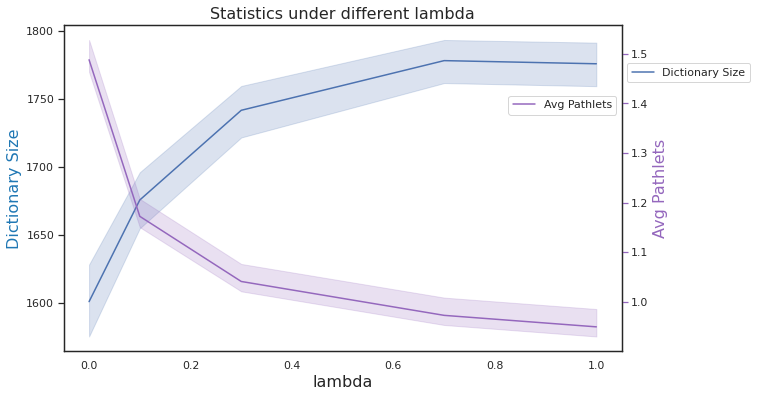

In [28]:
# 观察不同lambda下各项指标变化情况
label_list = ["all_loss","dict_size","average_pathlet","uncover","uncover","uncover","uncover"]

# for loss_index in [2]:
if 1:
    loss_index=1
    for i in range(len(final_loss)-1):
        if i ==0:
            plot_data=final_loss[i][loss_index]#[-1:]
        else:
            plot_data=plot_data+final_loss[i][loss_index]#[-1:]
    all_loss_df = pd.DataFrame(plot_data,columns=[label_list[loss_index]])
    if loss_index==2:
        all_loss_df["average_pathlet"]=all_loss_df["average_pathlet"]/len(tras)
    all_loss_df["index"]=all_loss_df.index
    all_loss_df["la"]=all_loss_df["index"]//epoch_num
    all_loss_df["la_value"] = all_loss_df["la"]
    for i in trange(len(all_loss_df)):
        all_loss_df["la_value"][i] = la_list[int(all_loss_df["la"][i])]

    # g=sns.lineplot(x="la_value", y=label_list[loss_index],
    #             data=all_loss_df,label=label_list[loss_index])
    # g.set(xlim=(7000,10500),ylim=(0,1500))
#绘制基础图层
sns.set_theme(style="white")
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:blue'
ax1.set_title('Statistics under different lambda', fontsize=16)
ax1.set_xlabel('lambda', fontsize=16)
ax1.set_ylabel('Dictionary Size', fontsize=16, color=color)
# 第一图条形图
ax1 =sns.lineplot(x="la_value", y=label_list[loss_index],
                data=all_loss_df,label=label_list[loss_index])
ax1.tick_params(axis='y')

plt.legend(labels = ['Dictionary Size'],loc = 0, bbox_to_anchor = (1,0.9))
# -------------------
if 1:
    loss_index=2
    for i in range(len(final_loss)-1):
        if i ==0:
            plot_data=final_loss[i][loss_index]#[-1:]
        else:
            plot_data=plot_data+final_loss[i][loss_index]#[-1:]
    all_loss_df = pd.DataFrame(plot_data,columns=[label_list[loss_index]])
    if loss_index==2:
        all_loss_df["average_pathlet"]=all_loss_df["average_pathlet"]/len(tras)

    all_loss_df["index"]=all_loss_df.index
    all_loss_df["la"]=all_loss_df["index"]//epoch_num
    
    all_loss_df["la_value"] = all_loss_df["la"]
    for i in trange(len(all_loss_df)):
        all_loss_df["la_value"][i] = la_list[int(all_loss_df["la"][i])]
        
# sns.set_theme(style="whitegrid")
ax2 = ax1.twinx()
color = 'tab:purple'
#第二个图，折线图
ax2.set_ylabel('Avg Pathlets', fontsize=16, color=color)
ax2 = sns.lineplot(x="la_value", y=label_list[loss_index],
                data=all_loss_df,label=label_list[loss_index],color=color)
plt.legend(labels = ['Avg Pathlets'],loc = 1, bbox_to_anchor = (1,0.8))
ax2.tick_params(axis='y', color=color)
# plt.legend(labels = [label_list[1],label_list[2]],loc = 0, bbox_to_anchor = (1,0.9))
# #显示绘制结果
plt.show()

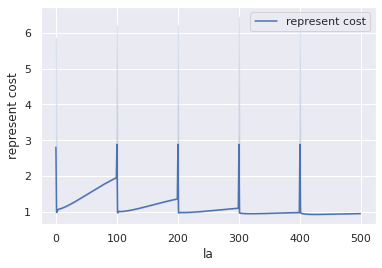

In [29]:
# rounding之后 绘制不同la下各项指标的变化
import seaborn as sns
sns.set_theme(style="darkgrid")
loss_index = 3
label_list = ["all_loss","dict_size","represent cost","represent loss"]
for loss_index in [2]:
    for i in range(len(rounding_loss_under_las)):
        if i ==0:
            plot_data=rounding_loss_under_las[i][loss_index]
        else:
            plot_data=plot_data+rounding_loss_under_las[i][loss_index]
            
    all_loss_df = pd.DataFrame(plot_data,columns=[label_list[loss_index]])
    all_loss_df["index"]=all_loss_df.index
    all_loss_df["la"]=all_loss_df["index"]//10
    if loss_index==2:
        all_loss_df["represent cost"]=all_loss_df["represent cost"]/len(tras)
    
    sns.lineplot(x="la", y=label_list[loss_index],
                data=all_loss_df,label=label_list[loss_index])
    # print(plot_data)
# 0.3的时候结果稍有点奇怪 所以换0.1再试一下



In [17]:

# a=np.array(rounding_loss_under_las,dtype=object)
# np.save('rounding_loss_under_las.npy',a)   # 保存为.npy格式

In [125]:
# 为rounding后得到的字典打上la的标签 方便下一步绘制不同la下pathlet分布的变化
pathlet_dictionary_list_labeled = pathlet_dictionary_list[0]
for pathlet_dictionary_index in range(1,len(pathlet_dictionary_list)):
    pathlet_dictionary_temp = pathlet_dictionary_list[pathlet_dictionary_index]
    pathlet_dictionary_temp["la_labeled"]=int(control_lambda_list[pathlet_dictionary_index])
    
    pathlet_dictionary_list_labeled = pd.concat([pathlet_dictionary_list_labeled,pathlet_dictionary_temp],axis=0)
pathlet_dictionary_list_labeled_cnt1 = pathlet_dictionary_list_labeled[pathlet_dictionary_list_labeled["cnt"]>1]
pathlet_dictionary_list_labeled_cnt1
pathlet_dictionary_list_labeled_cnt1[pathlet_dictionary_list_labeled_cnt1["la_labeled"]>=30].mean()
sns.displot(pathlet_dictionary_list_labeled[pathlet_dictionary_list_labeled["la_labeled"]>=30], x="len", kind="kde", fill=False)
# sns.displot(pathlet_dictionary_list_labeled[pathlet_dictionary_list_labeled["la_labeled"]==8], x="len",  kind="kde", fill=False)

In [ ]:
# 绘制不同la下pathlet分布的变化
fig = plt.figure(figsize=(18, 4), dpi=100)

ax1 = fig.add_subplot(151)
ax1.set(ylim=[-1.5,3000])
plt.xlabel('len of pathlet')  
plt.ylabel('num of pathlet')   
pathlet_dictionary_list[0]["len"].hist(bins=10,alpha = 1)

# ax2 = fig.add_subplot(152)
# ax2.set(ylim=[-1.5,3000]) 
# pathlet_dictionary_list[1]["len"].hist(bins=10,alpha = 1)

# ax3 = fig.add_subplot(153)
# ax3.set(ylim=[-1.5,900])
# pathlet_dictionary_list[2]["len"].hist(bins=10,alpha = 1)

# ax4 = fig.add_subplot(154)
# ax4.set(ylim=[-1.5,900])
# pathlet_dictionary_list[3]["len"].hist(bins=10,alpha = 1)

# ax4 = fig.add_subplot(155)
# ax4.set(ylim=[-1.5,900])
# pathlet_dictionary_list[4]["len"].hist(bins=10,alpha = 1)

# plt.xlabel('len of pathlet')  
# plt.ylabel('num of pathlet')   
# plt.legend(['10', '60'])
plt.show()  

<AxesSubplot:xlabel='lambda'>

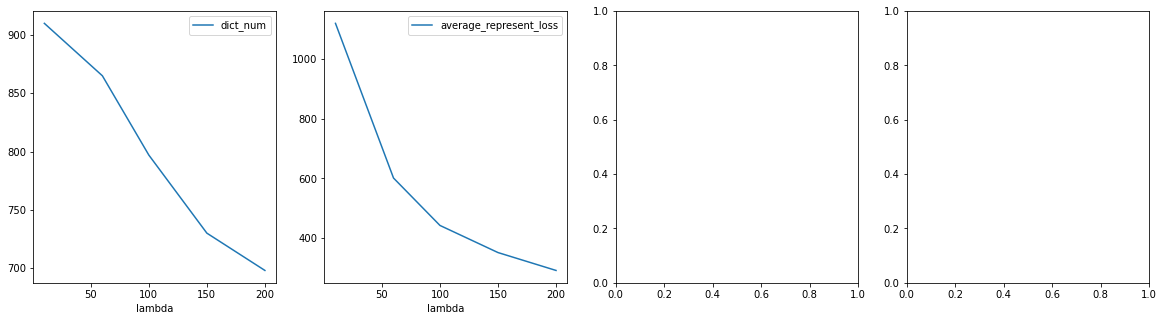

In [3]:
# # # 绘制不同la下字典大小和表达成本的变化
# import matplotlib.pyplot as plt
# import pandas as pd
# fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20, 5))
# res = [[10,910.0,1120],[60,865,601],[100,797,442],[150,730,351],[200,698,291]]
# df_res_record_con = pd.DataFrame(res,columns=["lambda","dict_num","average_represent_loss"])
# df_res_record_con.plot(x="lambda",y=["dict_num"],ax=axes[0])
# df_res_record_con.plot(x="lambda",y=["average_represent_loss"],ax=axes[1])


<AxesSubplot:>

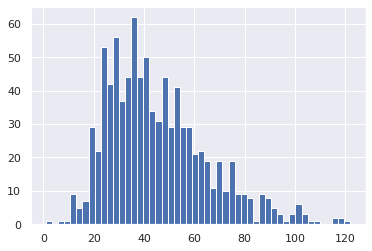

In [19]:
# 查看轨迹数目与用到的pathlet的数量的分布
df = pd.DataFrame(list(R_tensor_rounding.sum(0).cpu().numpy().round(1)),columns=['cnt'])
df.head()
df["cnt"].hist(bins=50)
# plt.xlabel('len of pathlet')  
# plt.ylabel('num of pathlet') 

## 如何使用字典表达test轨迹

In [ ]:
# 生成测试集的T矩阵
# tras_test = all_tras[100:200]

T_test = np.zeros((len(edge_list)+10, len(tras_test))) 
print(T_test.shape)
tra_index = 0
for i in trange(len(tras_test)):
    tra = tras_test[i]
    for edge in tra:
        T_test[edge_list.index(edge)][tra_index] = 1
    tra_index+=1
T_tensor_test=torch.from_numpy(T_test).cuda()
torch.norm(T_tensor_test,1)

In [23]:
# #the distribution of the num of edges pre tra
# tra_len=[]
# all_len=0
# for i in trange(len(tras_test)):
#     tra_len.append( len( tras_test[i]))
#     all_len+=len( tras_test[i])
# pd.DataFrame(tra_len,columns=["len"])["len"].hist(bins=20)
# plt.title("the distribution of the num of edges pre tra")
# print(all_len/100)

In [ ]:

for pathlet_dictionary in pathlet_dictionary_list:
    # 首先获得一个比较小的D和R
    p_picked_index = list(pathlet_dictionary["index"]) #这是被选中到字典中的p的index
    D_tensor_test = copy.deepcopy(D_tensor)
    D_tensor_test = D_tensor_test[:,p_picked_index]
    D_tensor_test.shape
    

    control_lambda_list = [10,60,100,150,200]
    control_lambda_list = [10,60]
    control_lambda_list = [0.3*len(tras_test)]
    initial_R = [
    torch.from_numpy(np.zeros(( len(list(pathlet_dictionary["index"])),len(tras_test)))) #全0初始化
    ]
    LR = 0.05
    final_loss = []
    epoch_num =5000
    value_distribution_list = []
    R_tensor_nonzero_ratio = []
    for control_lambda in control_lambda_list:
        la = control_lambda/len(tras_test)
        mu= 2000/len(tras_test)
        mu=0
        R_tensor_test = initial_R[0].cuda()
        # for R_tensor in  initial_R:
        R_tensor_test.requires_grad=True
        loss_his = [[],[],[],[],[],[],[]]
        opt  = torch.optim.Adam([R_tensor_test], lr=LR)
        scheduler_1 = StepLR(opt, step_size=100, gamma=0.95)
        diff_norm_num=1
        start_opt_rounding_ratio = 0.3
        for i in trange(epoch_num):
            temp_tensor = (D_tensor_test@R_tensor_test - T_tensor_test).cuda()
            
            a = torch.sum(torch.max(R_tensor_test,1).values).cuda()
            b = la*torch.norm(R_tensor_test,1) .cuda()
            c =  mu*(torch.norm((temp_tensor)*(temp_tensor),diff_norm_num)) .cuda()
            d =  mu*( torch.norm(D_tensor_test@(R_tensor_test*(torch.ones(R_tensor_test.size()).cuda()-R_tensor_test)),diff_norm_num)).cuda()
            # print(a,b,c,d)
            e = 10*torch.norm(relu(-1*temp_tensor),1)
            f = 1*torch.norm(relu(1*temp_tensor),1)
            res = (b+e).cuda()
            res.backward()
            # opt = torch.optim.SGD([R_tensor], lr=LR)
            opt.step()
            # R_tensor.data -= alpha*R_tensor.grad
            R_tensor_test.data=torch.maximum(R_tensor_test, torch.zeros(R_tensor_test.size()).cuda()) 
            R_tensor_test.data=torch.minimum(R_tensor_test, torch.ones(R_tensor_test.size()).cuda()) 
            # print(i,opt.param_groups[0]['lr'])
            # print(res)
            loss_his[0].append(res.item())
            loss_his[1].append(a.item())
            loss_his[2].append(b.item() )
            # loss_his[3].append(c.item())
            # loss_his[4].append(d.item())
            loss_his[5].append(e.item())
            loss_his[6].append(f.item())
            R_tensor_nonzero_ratio.append(torch.count_nonzero(R_tensor_test).item()/(R_tensor_test.size()[0]*R_tensor_test.size()[1]))
            scheduler_1.step()
            R_tensor_test.grad.zero_()

            if i%500==0:
                print("---all-loss:",(b+e).cpu().data.numpy().round(1),\
                    "--- dict num(max):",a.cpu().data.numpy().round(1) , \
                    "---average represent cost:",b.cpu().data.numpy().round(1)/n , \
                    # "---reconstruct error:",    mu*torch.norm((D_tensor@R_tensor - T_tensor)*(D_tensor@R_tensor - T_tensor),diff_norm_num).cpu().data.numpy().round(1), \
                    # "---rounding error:",    d.cpu().data.numpy().round(1)    )
                    "---reconstruct error:",    e.cpu().data.numpy().round(1) ,\
                    "---overlap error:",    f.cpu().data.numpy().round(1)       )
                    
        final_loss.append(loss_his)

In [31]:
# 随机rounding
from scipy.stats import bernoulli

cnt=0

pathlet_dictionary_list=[]
# for R_data_load in R_list[:]:
if 1:
    wuwu=1
    wuwu=math.log(torch.norm(T_tensor,1).cpu().data.numpy().round(1))
    R_data_star = copy.deepcopy(R_tensor_test)
    R_data = copy.deepcopy(R_tensor_test)
    R_data.requires_grad=False
    for i in trange(R_data_star.shape[0]):
        for j in range(R_data_star.shape[1]):
            if(R_data_star[i][j]>0.001):
                R_data[i][j] = bernoulli.rvs(size=1,p=min(1,wuwu*R_data_star[i][j].cpu().detach().numpy()))[0]
            else:
                R_data[i][j]=0
    # .data = R_data_load
    R_tensor_rounding = R_data.cuda()
    print("-------------------------------")
    print("wuwu:",wuwu)
    temp_tensor = (D_tensor_test@R_tensor_rounding - T_tensor_test).cuda()
    a = torch.sum(torch.max(R_tensor_rounding,1).values).cuda()
    b = la*torch.norm(R_tensor_rounding,1) .cuda()
    e = torch.norm(relu(-1*temp_tensor),1)
    print("---all-loss:",(a+b+e).cpu().data.numpy().round(1),\
        "--- dict num(max):",a.cpu().data.numpy().round(1) , \
        "---average represent cost:",b.cpu().data.numpy().round(1)/n , \
        # "---reconstruct error:",    mu*torch.norm((D_tensor@R_tensor - T_tensor)*(D_tensor@R_tensor - T_tensor),diff_norm_num).cpu().data.numpy().round(1), \
        # "---rounding error:",    d.cpu().data.numpy().round(1)    )
        "---reconstruct error:",    e.cpu().data.numpy().round(1)    )


100%|██████████| 22282/22282 [02:20<00:00, 158.62it/s]

-------------------------------
wuwu: 9.937309101011639
---all-loss: 14263.8 --- dict num(max): 9995.0 ---average represent cost: 4.75565509518477 ---reconstruct error: 22.0


直接无脑运行到这里

Text(0.5, 1.0, 'average represent cost')

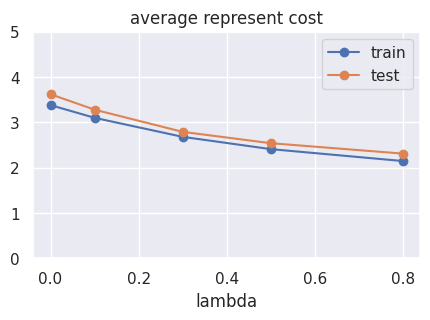

In [ ]:
# 综合性能绘图
performance = [[0, 1658.691, 3.38,0.91,3.62],
 [0.1, 1697.415, 3.1,0.79,3.28],
 [0.3, 1684.31, 2.68,0.58,2.79],
 [0.5, 1654.858, 2.4090,0.55,2.54],
 [0.8, 1606.441, 2.146,0.61,2.31]]
df_res_record = pd.DataFrame(performance,columns=["lambda","dict_num","train","average reconstruction cost","test"])

fig = plt.figure(figsize=(5, 3), dpi=100)
# ax1 = fig.add_subplot(121)
# ax1.set(ylim=[1,4])
# df_res_record.plot(x="lambda",y=["average represent cost"],marker='o',ax=ax1)
# # ax2 = fig.add_subplot(122)
# # ax2.set(ylim=[-1.5,3000])
# # df_res_record.plot(x="lambda",y=["dict_num"],marker='o',ax=ax2)

ax2 = fig.add_subplot(111)
ax2.set(ylim=[0,5])
df_res_record.plot(x="lambda",y=["train"],marker='o',ax=ax2)
df_res_record.plot(x="lambda",y=["test"],marker='o',ax=ax2)
plt.title("average represent cost")

In [ ]:
# 计算相似度
import torch.nn.functional as F
sim_matrix = np.zeros((R_tensor.shape[1],R_tensor.shape[1]))
for i in trange(R_tensor.shape[1]):
    for j in range(R_tensor.shape[1]):
        tmp_a = R_tensor[:][i]
        tmp_b = R_tensor[:][j]
        sim_matrix[i,j] = F.cosine_similarity(tmp_a, tmp_b, dim=0)
np.save('sim_matrix.npy',sim_matrix)   # 保存为.npy格式

100%|██████████| 893/893 [01:58<00:00,  7.51it/s]


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
dis_4_cluster = R_tensor.cpu().detach().numpy().T
# tsneData
# 构造数据样本点集X，并计算K-means聚类
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
kmeans = KMeans(n_clusters=6, random_state=1,max_iter =300,n_init=10).fit(tsneData)

# 输出及聚类后的每个样本点的标签（即类别），预测新的样本点所属类别
print(kmeans.labels_)
# print(kmeans.predict([[0, 0], [4, 4], [2, 1]]))
kmeans_res_df = pd.DataFrame(kmeans.labels_)
kmeans_res_df.hist()
np.save('./kmeans_labels.npy',kmeans.labels_)

/tmp/ipykernel_578/3528420845.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  R_tensor_rounding_subset_test = R_tensor_rounding_subset[p_picked_index,:]
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_578/3528420845.py:27: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = ax.scatter(tsneData[0:,0], tsneData[0:,1],marker='x',s=35,c='b',edgecolors='b')


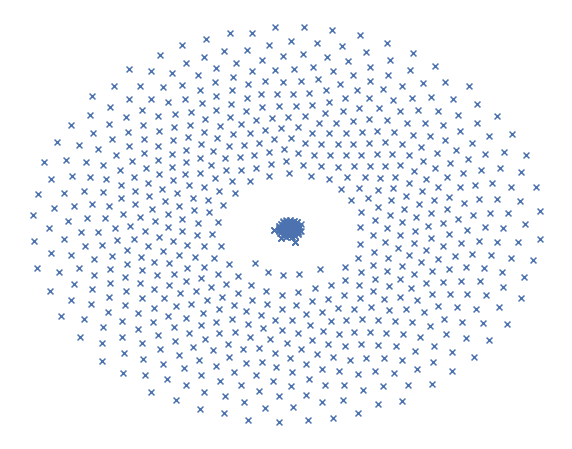

In [ ]:
# 降维二维可视化R矩阵
R_tensor_rounding_subset = copy.deepcopy(R_tensor_rounding)
p_picked_index = list(pathlet_dictionary["index"]) #这是被选中到字典中的p的index
R_tensor_rounding_subset_test = R_tensor_rounding_subset[p_picked_index,:]
R_tensor_rounding_subset_test.T.shape

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# vecArr = np.random.rand(1000,512) #构造1000个512维向量, 换成实际需要聚类的向量即可
tsneData = TSNE().fit_transform(R_tensor_rounding_subset_test.T.cpu())

# case study 观察tsne中靠近的点是什么样的
# near_point = []
# for i in range(len(tsneData)):
#     x=tsneData[i,0]
#     y=tsneData[i,1]
#     if x>0 and x<10 and y>10 and y<20:
#         print(i)
#         near_point.append(i)
#开始进行可视化
f = plt.figure(figsize=(10,8))
ax = plt.subplot(aspect='equal')
# for i in near_point:
    # sc = ax.scatter(tsneData[i,0], tsneData[i,1],marker='o',s=100,c='w',edgecolors='r',linewidths=2)
sc = ax.scatter(tsneData[0:,0], tsneData[0:,1],marker='x',s=35,c='b',edgecolors='b')
plt.xlim(-50,50)
plt.ylim(-50,50)
ax.axis('off')
ax.axis('tight')
plt.show()

